In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
%matplotlib inline

In [3]:
#Parameters (Gaussian units)
charges = [1.0, -1.0]
labels = ['q=+1', 'q=-1']
q_styles = {'drift': ['-', ':'], 'total': ['--', '-.']}

m, c = 1.0, 1.0
B = np.array([0.0, 0.0, 5.0])
B_mag = np.linalg.norm(B)
b_hat = B / B_mag

#Initial conditions
r0 = np.array([0.0, 0.0, 0.0])
v0 = np.array([0.3, 0.8, 0.3])

#V parallel and perpendicular to B
v_par = np.dot(v0, b_hat) * b_hat
v_perp = v0 - v_par

#Time parameters
dt = 0.1
N = 200
t = np.arange(N) * dt

In [4]:
#Fields responsible for the drifts
E = np.array([1.0, -0.8, 0.0])
dE_dt = np.array([0.3, 0.5, 0.0])
g = np.array([0.04, -0.8, 0.0])
gradB = np.array([-11.1, 5.5, 0.0])
R_vec = np.array([0.006, 0.05, 0.0])

def compute_drifts(q):
    #Drift velocities
    v_E = (c/B_mag**2) * np.cross(E,    B)
    v_P = (m*c/(q*B_mag**2)) * np.cross(dE_dt, B)
    v_G = (m*c/(q*B_mag**2)) * np.cross(g,    B)
    v_gradB = (m*(np.linalg.norm(v_perp)**2)/(2*q*B_mag**3)) * np.cross(B, gradB)
    v_curv = (m*(np.dot(v_par, v_par))/(q*(np.linalg.norm(R_vec)**2)*B_mag**2)) * np.cross(R_vec, B)
    return [v_E, v_P, v_G, v_gradB, v_curv]

#Trajectories
titles = [r'$E\times B$ Drift', 'Polarization Drift', 'Gravitational Drift', r'$\nabla B$ Drift', 'Curvature Drift']
trajs_drift = []
trajs_total = []
for qi, q in enumerate(charges):
    drifts = compute_drifts(q)
    #Drift trajectories
    td = [r0[:2] + np.outer(t, v[:2]) for v in drifts]
    #Helical trajectories
    gamma   = 1.0/np.sqrt(1 - (np.linalg.norm(v0)/c)**2)
    omega_c = q * B_mag/(m*gamma*c)
    b_cross = np.cross(b_hat, v_perp)
    r_helix = (r0
               + np.outer(t, v_par)
               + (v_perp/omega_c) * np.sin(omega_c*t)[:,None]
               - (b_cross/omega_c) * (np.cos(omega_c*t)-1)[:,None])
    #Both
    tt = [(r_helix + np.outer(t, v))[:,:2] for v in drifts]
    trajs_drift.append(td)
    trajs_total.append(tt)

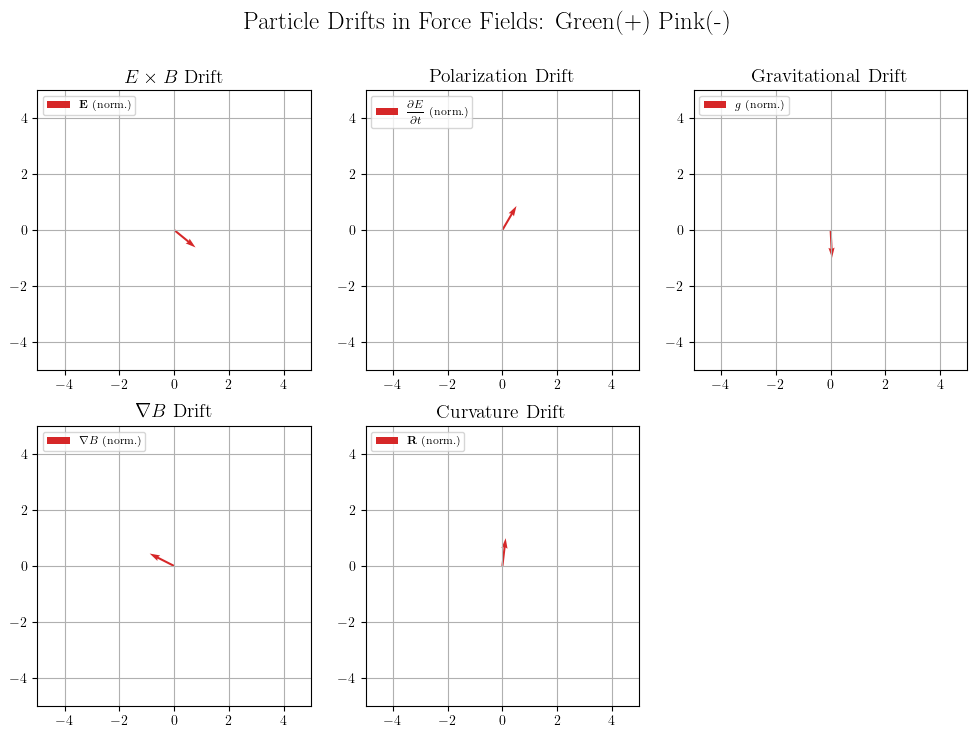

In [12]:
#Figure configuration 
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle(r'Particle Drifts in Force Fields: Green(+) Pink(-)',fontsize=18)
axes = axes.flatten()
for ax in axes[:5]:
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.grid(True)
axes[5].axis('off')

#Plotting vectors for the fields
fields = [E, dE_dt, g, gradB, R_vec]
field_labels = [r'$\mathbf{E}$',r'$\displaystyle\frac{\partial E}{\partial t}$',r'$g$',r'$\nabla B$',r'$\mathbf{R}$']

for idx in range(5):
    ax = axes[idx]
    ax.set_title(titles[idx], fontsize=14)
    #2D projection of the fields
    f = fields[idx][:2]
    #Drawing of the vector
    ax.quiver(0, 0, f[0], f[1], #Tail at the origin and x,y components of the field
              angles='xy', scale_units='xy',
              scale=np.hypot(*f), #Divide by its own length
              pivot='tail',
              color='C3', label=field_labels[idx]+' (norm.)')
    #Updating label
    axes[idx].legend(loc='upper left', fontsize=8)
    

In [13]:
#For each drift and charge we'll create the particle and its path
artists = []  # list [drift_idx][charge_idx] -> tuple

for idx in range(5):
    charge_artists = []
    for qi in range(2):
        label = labels[qi] 
        l_d, = axes[idx].plot([], [], lw=2, linestyle=q_styles['drift'][qi])
        p_d, = axes[idx].plot([], [],marker='o')
        l_t, = axes[idx].plot([], [],lw=2, linestyle=q_styles['total'][qi])
        p_t, = axes[idx].plot([], [],marker='s')
        charge_artists.append((l_d, p_d, l_t, p_t))
    artists.append(charge_artists) 
    
#Clearing to prevent garbage data
def init():
    for group in artists:
        for (l_d, p_d, l_t, p_t) in group:
            l_d.set_data([], [])
            p_d.set_data([], [])
            l_t.set_data([], [])
            p_t.set_data([], [])
    """The return its equivalent to writing
    out = []
    for grp in artists:
        for tup in grp:
            for art in tup:
            out.append(art)
    return out
    """
    return [art for grp in artists for tup in grp for art in tup]


def update(frame):
    for idx, group in enumerate(artists):
        for qi, (l_d, p_d, l_t, p_t) in enumerate(group):
            #drift
            td = trajs_drift[qi][idx]
            l_d.set_data(td[:frame,0], td[:frame,1])
            p_d.set_data([td[frame,0]], [td[frame,1]])
            #Total
            tt = trajs_total[qi][idx]
            l_t.set_data(tt[:frame,0], tt[:frame,1])
            p_t.set_data([tt[frame,0]], [tt[frame,1]])
    return [art for grp in artists for tup in grp for art in tup]

#Save animation
ani = animation.FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=50)
ani.save('drifts.gif', writer='pillow', fps=20)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>